## Plan to focus on Metabolism -> Other Metatbolism {2 members} 
- [x] G7490 --> add 23-Diaminopropanoate transport and use it as sole carbon source (iffy)
- [x] G7408 --> use α-D-fructopyranose (CPD-10725), β-D-fructopyranose (CPD-10726), and keto-D-fructose (CPD-15382) as sole carbon source

In [17]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import cvxpy as cp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import bulk_name_to_idx, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

In [2]:
# load basal new model
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba_basal = output['listeners']['fba_results']
bulk = pd.DataFrame(output['bulk'])
f = open(folder + 'agent_steps.pkl', 'rb')
agent_basal = dill.load(f)
f.close()

In [3]:
# get commonly stored variables
metabolism_basal = agent_basal['ecoli-metabolism-redux-classic']
stoichiometry = metabolism_basal.stoichiometry.copy()
reaction_names = metabolism_basal.reaction_names
kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions
fba_new_reaction_ids = metabolism_basal.parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = metabolism_basal.parameters['fba_reaction_ids_to_base_reaction_ids']
binary_kinetic_idx = metabolism_basal.binary_kinetic_idx
metabolites = metabolism_basal.metabolite_names

S = stoichiometry.copy()
S = pd.DataFrame(S, index=metabolites, columns=reaction_names)
homeostatic_count = pd.DataFrame(fba_basal["homeostatic_metabolite_counts"], columns=metabolism_basal.homeostatic_metabolites).loc[24, :].copy()
homeostatic = pd.DataFrame(fba_basal["target_homeostatic_dmdt"], columns=metabolism_basal.homeostatic_metabolites).loc[24, :].copy()
maintenance = pd.DataFrame(fba_basal["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]

FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

# load variables from track_reaction_usage.ipynb

In [4]:
%store -r df_reaction_flux df_reaction_track df_gene_usage unused_kinetic_gene

# Define functions for testing

In [5]:
def get_subset_S(S, met_of_interest):
    S_met = S.loc[met_of_interest, :]
    S_met = S_met.loc[:,~np.all(S_met == 0, axis=0)]
    return S_met, S_met.columns

def test_NetworkFlowModel(objective_weights,
                          uptake_addition = set([]), uptake_removal = set([]), new_exchange_molecules = set([]),
                          add_metabolite = None, add_reaction = None, add_kinetic = None, remove_reaction = None, 
                          # add_homeostatic_demand = None, force_reaction = None):
    # update exchanges
    uptake = metabolism_basal.allowed_exchange_uptake.copy()
    uptake = set(uptake)
    uptake = uptake | uptake_addition
    uptake = uptake - uptake_removal
    
    exchange_molecules = metabolism_basal.exchange_molecules.copy()
    exchange_molecules = exchange_molecules | new_exchange_molecules
    
    # update stoichiometry
    reaction_names = metabolism_basal.reaction_names.copy()
    kinetic_reaction_ids = metabolism_basal.kinetic_constraint_reactions.copy()
    kinetic = pd.DataFrame(fba_basal["target_kinetic_fluxes"], columns=metabolism_basal.kinetic_constraint_reactions).loc[24, :].copy()
    metabolites = metabolism_basal.metabolite_names.copy()
    homeostatic = pd.DataFrame(fba_basal["target_homeostatic_dmdt"], columns=metabolism_basal.homeostatic_metabolites).loc[24, :].copy()
    homeostatic_counts = homeostatic_count.copy() * metabolism_basal.counts_to_molar.asNumber()
    
    S_new = stoichiometry.copy()
    
    if add_metabolite is not None: # add to metabolites list because they are currently not included in the model
        for m in add_metabolite:
            if m not in metabolites:
                metabolites.append(m)
        # append rows of zeros to S_new of length add_metabolite
        S_new = np.concatenate((S_new, np.zeros((len(add_metabolite), S_new.shape[1]))), axis=0)
        print(S_new.shape)
    
    if add_reaction is not None:
        # assert add_reaction is a dictionary
        assert isinstance(add_reaction, dict)
        
        for r,s in add_reaction.items():
            if r not in reaction_names:
                reaction_names.append(r)
            # append columns of reaction stoich to S_new of length add_reaction
            new_reaction = np.zeros((S_new.shape[0], 1))
            for m, v in s.items():
                new_reaction[metabolites.index(m), 0] = v
            S_new = np.concatenate((S_new, new_reaction), axis=1)
        print(S_new.shape)
    
    if add_kinetic is not None:
        # assert add_kinetic is a dictionary
        assert isinstance(add_kinetic, dict)
        
        for r, v in add_kinetic.items():
            if r not in kinetic_reaction_ids:
                kinetic_reaction_ids.append(r)
                kinetic[r] = v
                
    if remove_reaction is not None:
        for r in remove_reaction:
            r_idx = reaction_names.index(r)
            S_new = np.delete(S_new, r_idx, axis=1)
            reaction_names.remove(r)
            if r in kinetic_reaction_ids:
                kinetic_reaction_ids.remove(r)
                del kinetic[r]
                
    if force_reaction is not None:
        force_reaction_idx = np.array([reaction_names.index(r) for r in force_reaction])
    else:
        force_reaction_idx = force_reaction

    if add_homeostatic_demand is not None:
        # assert add_homeostatic_demand is a set
        assert isinstance(add_homeostatic_demand, list)
        
        for met in add_homeostatic_demand:
            homeostatic[met] = 100
            homeostatic_counts[met] = 1
            
    print(f'Force Reaction ID is:',force_reaction_idx)
    # Solve NetworkFlowModel
    model = NetworkFlowModel(
            stoich_arr=S_new,
            metabolites=metabolites,
            reactions=reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=kinetic_reaction_ids,
            free_reactions=FREE_RXNS)
    model.set_up_exchanges(exchanges=exchange_molecules, uptakes=uptake)
    solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_counts, # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())), # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            # binary_kinetic_idx=binary_kinetic_idx, #7646
            binary_kinetic_idx=None,
            force_flow_idx=force_reaction_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP) #SCS. ECOS
    print(f'Optimal objective function reached is: {solution.objective}')
    return solution.velocities, reaction_names, S_new, metabolites, kinetic

# G7490 --> ygeX --> 4.3.15-RXN
23-Diaminopropanoate[CCO-CYTOSOL] is dem no production. TODO: add transport via TRANS-RXN0-265 and TRANS-RXN0-612

In [6]:
# try removing fifth 2.1.1.79 reaction to see if this one will be used
add_reaction = {
    'TEMP-TRANSPORT-23-Diaminopropanoate[p]->[c]': {
        '23-Diaminopropanoate[p]': -1,
        '23-Diaminopropanoate[c]': 1
    },
    'TEMP-TRANSPORT-23-Diaminopropanoate[p]->[c] (reverse)': {
        '23-Diaminopropanoate[p]': 1,
        '23-Diaminopropanoate[c]': -1
    },
    'TEMP-TRANSPORT-23-Diaminopropanoate[e]->[p]': {
        '23-Diaminopropanoate[e]': -1,
        '23-Diaminopropanoate[p]': 1
    },
    'TEMP-TRANSPORT-23-Diaminopropanoate[e]->[p] (reverse)': {
        '23-Diaminopropanoate[e]': 1,
        '23-Diaminopropanoate[p]': -1
    }
}

add_metabolite = ['23-Diaminopropanoate[e]', '23-Diaminopropanoate[p]']

uptake_addition = set([
                       '23-Diaminopropanoate[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['23-Diaminopropanoate[e]']) 

objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}

In [7]:

solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights,
                                            uptake_addition=uptake_addition,  uptake_removal=uptake_removal, new_exchange_molecules=new_exchange_molecules,
                                            add_reaction=add_reaction, add_metabolite=add_metabolite,
)

sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

met_of_interest = ['23-Diaminopropanoate[e]', '23-Diaminopropanoate[p]', '23-Diaminopropanoate[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

(6078, 9358)
(6078, 9362)
Force Reaction ID is: None
Optimal objective function reached is: 45017.52665763971


,flux,is_new,kinetic
4.3.1.15-RXN,390811.666667,New Reactions,471.0
TEMP-TRANSPORT-23-Diaminopropanoate[p]->[c],390811.666667,TEMP,False
TEMP-TRANSPORT-23-Diaminopropanoate[p]->[c] (reverse),-0.000000,TEMP,False
TEMP-TRANSPORT-23-Diaminopropanoate[e]->[p],390811.666667,TEMP,False
TEMP-TRANSPORT-23-Diaminopropanoate[e]->[p] (reverse),-0.000000,TEMP,False


it will for sure be used in the model. if we add the transport reaction and use it as sole carbon source, it will be used.

# G7408 --> yqaB --> RXN0-5186
use BETA-D-FRUCTOSE and CPD-10723 as sole carbon source

In [8]:
CPD-10723
CPD-10725
CPD-10726
CPD-15382
FRU

NameError: name 'CPD' is not defined

In [ ]:
uptake_addition = set([
                       'CPD-10723[e]',
                       #    'FRU1P[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                     ])
new_exchange_molecules = set(['CPD-10723[e]']) 
remove_reaction = ['1PFRUCTPHOSN-RXN']
force_reaction = ['RXN0-5186__G7408-MONOMER']
force_reaction = None
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}
# objective_weights = {'secretion': 0.01, 'kinetics': 0.0001}

In [ ]:
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights,
                                            uptake_addition=uptake_addition,  uptake_removal=uptake_removal, 
                                            force_reaction=force_reaction, remove_reaction=remove_reaction,
)

sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)

met_of_interest = ['CPD-10723[e]', 'CPD-10723[p]', 'FRU1P[c]', 'FRU1P[p]', 'FRU1P[e]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
rxns
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

# Scratch

In [9]:
for rxn in metabolism_basal.reaction_names:
    if 'RXN-16937' in rxn:
        print(rxn)

RXN-16937


In [225]:
uptake_addition = set([
                       'T2-C4-DECADIENYL-COA[c]'
                       #    'FRU1P[e]',
                       ])
uptake_removal = set([
                      # "OXYGEN-MOLECULE[p]",
                      'GLC[p]',
                      # 'Pi[p]',
                      #   'SULFATE[e]',
                      #   'AMMONIUM[e]'
                     ])

# add_homeostatic_demand = ['HOMO-SER[p]', 'CPD-15554[p]', 'THR[p]']
# add_homeostatic_demand = ['T2-C4-DECADIENYL-COA[c]']

force_reaction = ['TRANS-RXN-242', 'TRANS-RXN-242A', 'TRANS-RXN0-0244']
# force_reaction = ['RXN0-2441']
# force_reaction = None

objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.000001}
# objective_weights = {'secretion': 0.01, 'kinetics': 0.0001}
solution_flux, test_reaction_names, S_new, test_metabolites, test_kinetic = test_NetworkFlowModel(
                                            objective_weights,
                                            uptake_addition=uptake_addition, 
                                            # uptake_removal=uptake_removal,
                                            # add_homeostatic_demand=add_homeostatic_demand,    
                                            # force_reaction=force_reaction,
)
sim_flux = pd.DataFrame({
    'flux': solution_flux,
    'is_new': [
        'New Reactions' if id in fba_new_reaction_ids 
        else 'TEMP' if id in add_reaction.keys() 
        else 'Old Reactions' 
            for id in test_reaction_names
    ]
}, index=test_reaction_names)
#18391.51691059434

Force Reaction ID is: None
Optimal objective function reached is: 21701.904583182


In [226]:
met_of_interest = ['T2-C4-DECADIENYL-COA[c]']
S_new = pd.DataFrame(S_new, index=test_metabolites, columns=test_reaction_names)
S_met, rxns  = get_subset_S(S_new, met_of_interest)
# rxns = ['ABC-16-RXN-MALTOSE/ATP/WATER//MALTOSE/ADP/Pi/PROTON.41.', 'TRANS-RXN0-504', 'TRANS-RXN0-503']
rxn_flux = sim_flux.loc[rxns]
rxn_flux['kinetic'] = [test_kinetic[r] if r in kinetic_reaction_ids else False for r in rxn_flux.index]
rxn_flux

,flux,is_new,kinetic
DIENOYLCOAREDUCT-RXN (reverse),312.0,New Reactions,False


In [178]:
for met in homeostatic.index.tolist():
    if 'ENTEROBACTIN' in met:
        print(met, homeostatic[met])

ENTEROBACTIN[c] 15.0


In [158]:
homeostatic

2-3-DIHYDROXYBENZOATE[c]    20.0
2-KETOGLUTARATE[c]          53.0
2-PG[c]                     13.0
2K-4CH3-PENTANOATE[c]       20.0
4-AMINO-BUTYRATE[c]         46.0
                            ... 
NA+[p]                      15.0
OXYGEN-MOLECULE[p]          15.0
FE+3[p]                     15.0
CA+2[p]                     15.0
Pi[p]                       15.0
Name: 24, Length: 172, dtype: float64

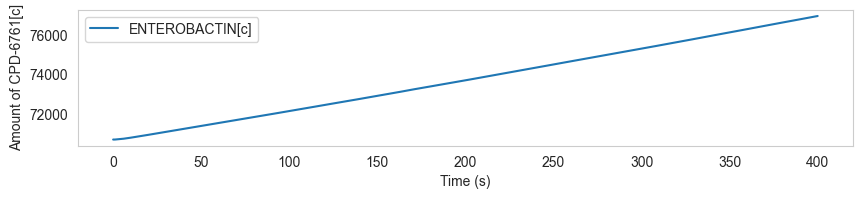

In [180]:
molecule_of_interest = ['ENTEROBACTIN[c]','AMINEOXID-CPLX[c]']
dem_of_interest_bulk_idx = bulk_name_to_idx(molecule_of_interest, metabolism_basal.bulk_ids)

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(bulk[dem_of_interest_bulk_idx[0]], label="ENTEROBACTIN[c]")
# plt.plot(bulk[dem_of_interest_bulk_idx[1]], label="CPD-18260[c]")
# plt.plot(bulk[dem_of_interest_bulk_idx[2]], label="CPD-14332[c]")
plt.xlabel('Time (s)')
plt.ylabel("Amount of CPD-6761[c]")
plt.legend()
plt.grid()

In [40]:
dem_of_interest_bulk_idx

array([5333, 2105])

In [53]:
basal_sim_fluxes = pd.DataFrame(fba_basal['solution_fluxes'], columns=metabolism_basal.reaction_names).mean(axis=0)
basal_sim_fluxes = pd.DataFrame(fba_basal['solution_fluxes'], columns=metabolism_basal.reaction_names).loc[340:360,:]
basal_sim_fluxes['RXN0-5266-CPD-9956/OXYGEN-MOLECULE/PROTON//UBIQUINONE-8/WATER/PROTON.59.']

340   -0.0
341   -0.0
342   -0.0
343   -0.0
344   -0.0
345   -0.0
346   -0.0
347   -0.0
348   -0.0
349   -0.0
350   -0.0
351   -0.0
352   -0.0
353   -0.0
354   -0.0
355   -0.0
356   -0.0
357   -0.0
358   -0.0
359   -0.0
360   -0.0
Name: RXN0-5266-CPD-9956/OXYGEN-MOLECULE/PROTON//UBIQUINONE-8/WATER/PROTON.59., dtype: float64

In [45]:
for reaction in kinetic_reaction_ids:
    if 'RXN-19492' in reaction:
        print(reaction)

In [147]:
for reaction in reaction_names:
    if 'ACONITATEHYDR-RXN' in reaction:
        print(reaction)

ACONITATEHYDR-RXN
ACONITATEHYDR-RXN (reverse)
